In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [22]:
df_train = pd.read_csv('heart_adapt_train.csv')
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


- Есть пропуски в столбце __AGE__, их мало ~ 10%, попробуем с ними поработать, в столбце __Cholesterol__ - здесь уже пропусков больше ~21% - тоже поработаем и один пропуск в __RestingBP__ - его трогать не буду

- Типы столбцов соотвествуют

- Целевой признак __HeartDisease__

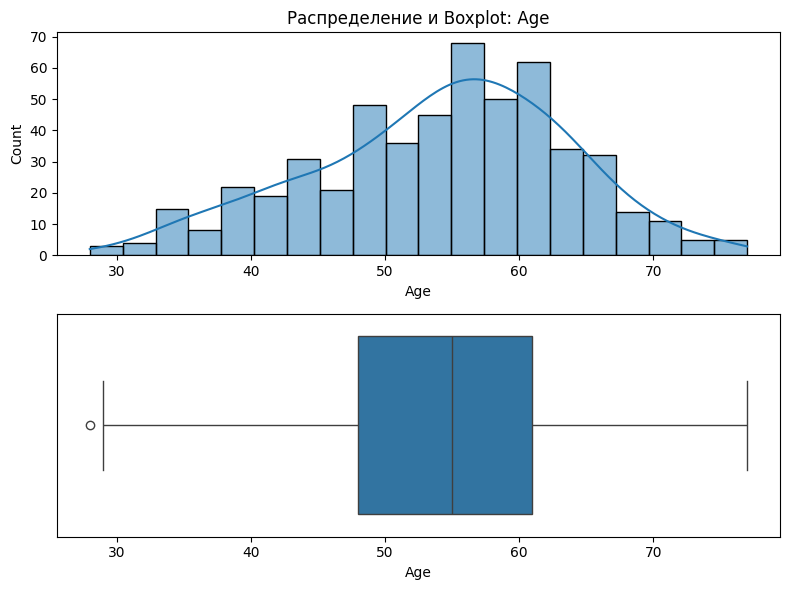

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_train['Age'], kde=True, ax=ax1, bins=20)
ax1.set_title('Распределение и Boxplot: Age')
ax1.set_ylabel('Count')

sns.boxplot(x=df_train['Age'], ax=ax2)
ax2.set_xlabel('Age')
ax2.set_yticks([])

plt.tight_layout()
plt.show()

Распределение __НЕнормальное__, скошенно вправо, выбросов нет

Пропуски буду заполнять медианой

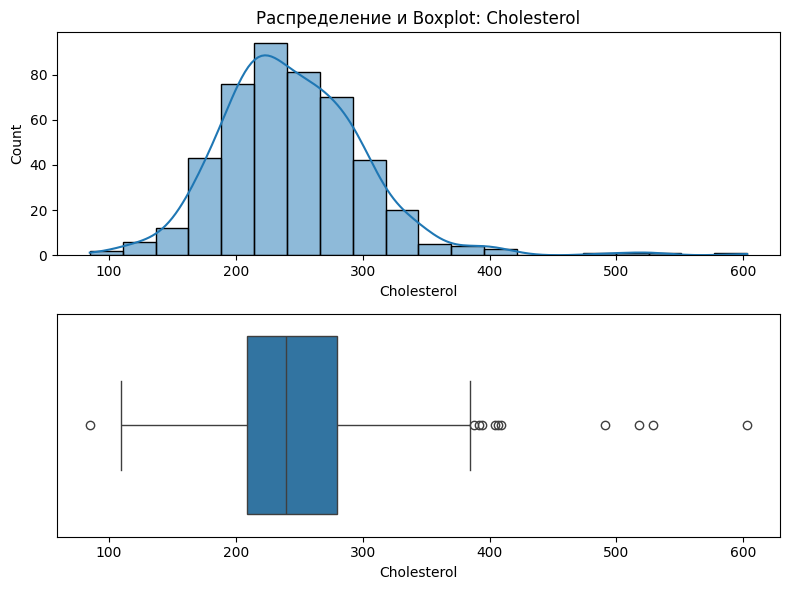

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_train['Cholesterol'], kde=True, ax=ax1, bins=20)
ax1.set_title('Распределение и Boxplot: Cholesterol')
ax1.set_ylabel('Count')

sns.boxplot(x=df_train['Cholesterol'], ax=ax2)
ax2.set_xlabel('Cholesterol')
ax2.set_yticks([])

plt.tight_layout()
plt.show()

Распределение __НЕнормальное__, есть выбросы

Здесь пропуски буду заполнять медианой

In [26]:
df_train['HeartDisease'].value_counts()

HeartDisease
1    381
0    208
Name: count, dtype: int64

Классы __НЕсбалансированы__

Отделяем целевую переменную от фичей

In [27]:
X = df_train.drop(columns=['HeartDisease'])
y = df_train['HeartDisease']

In [28]:
col_num = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
col_cat = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [29]:
numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_pipe, col_num),
    ('cat', categorical_pipe, col_cat)
])

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(class_weight='balanced'))
])

In [30]:
param_grid = [
    {
        'clf': [LogisticRegression(class_weight='balanced')],
        'clf__C': [0.1, 1, 3, 10]
    },
    {
        'clf': [RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)],
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 8, 12, 16],
        'clf__min_samples_split': [2, 5, 10]
    }
]

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    refit=True
)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [33]:
search.fit(X_train, y_train)

,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'clf': [LogisticRegre...ht='balanced')], 'clf__C': [0.1, 1, ...]}, {'clf': [RandomForestC...ndom_state=42)], 'clf__max_depth': [None, 8, ...], 'clf__min_samples_split': [2, 5, ...], 'clf__n_estimators': [100, 200, ...]}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [34]:
print('Best CV ROC-AUC:', search.best_score_)
print('Best params:', search.best_params_)

Best CV ROC-AUC: 0.9335738539898133
Best params: {'clf': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'clf__max_depth': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [35]:
best_model = search.best_estimator_

Проверим на тестовых данных

In [39]:
df_test = pd.read_csv('heart_adapt_test.csv')

X_test = df_test.drop(columns=['HeartDisease'])
y_test = df_test['HeartDisease']

In [40]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]
print('Test ROC-AUC:', roc_auc_score(y_test, y_test_proba))

Test ROC-AUC: 0.9048368953880764


Условия задания, что ROC-AUC > 0.87 мы добились